In [1]:
##############################
#Training loop for NNs       #
#Maintainer: Christopher Chan#
#Version: 0.3.0              #
#Date: 2022-04-25            #
##############################

import os
import sys
import torch
import pathlib
import time
import re
import PIL
import random
import ray
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import segmentation_models_pytorch as smp
from ray import tune
from ray.tune.suggest.bohb import TuneBOHB
from ray.tune.schedulers import HyperBandForBOHB
from scipy import ndimage
from PIL import Image
from torch import optim
from tqdm import tqdm
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split, ChainDataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from Networks import Five_UNet, Four_UNet
from dataloader import BuildingDataset
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))

print(f"Training on device {device}.")

#td_KBYSamp = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/td_KBY")
#td_DZKSamp = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK")
#td_DZKNSamp = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/td_DZKN")

td_KBY10 = os.path.abspath("/home/mnt/HOTOSM_data/Kakuma10cm/Kalobeyei/td_KBY")
td_DZK10 = os.path.abspath("/home/mnt/HOTOSM_data/Dzaleka10cm/td_DZK")
td_DZKN10 = os.path.abspath("/home/mnt/HOTOSM_data/Dzaleka_N10cm/td_DZKN")

td_KBY15 = os.path.abspath("/home/mnt/HOTOSM_data//Kakuma15cm/Kalobeyei/td_KBY")
td_DZK15 = os.path.abspath("/home/mnt/HOTOSM_data/Dzaleka15cm/td_DZK")
td_DZKN15 = os.path.abspath("/home/mnt/HOTOSM_data/Dzaleka_N15cm/td_DZKN")

Training on device cuda.


## Change class label from 2 to 1 for binary

for root, dirs, filename in os.walk(os.path.join(td_DZK10, "LBL")):
    for i in filename:
        if i.endswith(".png"):
            png = Image.open(root + "/" + i)
            px = png.load()

            for x in range(png.size[0]):
                for y in range(png.size[1]):
                    if px[x, y] == 2:
                        px[x, y] = 1
                        
                png.save(root + "/" + i, "PNG")

### Train Val Test split

Splitting exists, skipping Train, Val, Test split.
Total images and labels pair in DataLoader: 22586
Concatenated TRAINING images and labels pair: 18242 :
Concatenated VALIDATION images and labels pair: 3909 :
Concatenated TESTING images and labels pair: 435 :
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


Text(0.5, 1.0, 'Train Label')

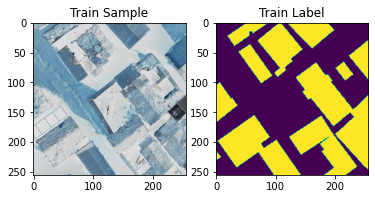

In [4]:

# Below is a set of relatively complex functions which:
# Perform the train, val, test split at a rounded ratio of 62%, 27%, and 10% based on each sets of imagery
# This will be followed by first pseudo changing the name of _LBL_ to _IMG_ to match the split imagery
# Lastly, once the correct LBL files are matched, 

def tvt_split(td):
    
    img_ls = []
    
    for root, dirs, filename in os.walk(os.path.join(td, "IMG")):
        for i in filename:
            if i.endswith(".png"):
                img_ls.append(root + "/" + i)
        
        img_ls = BuildingDataset(img_ls, _)
        
        train_IMG, val_IMG, test_IMG = random_split(img_ls.png_dir, [int(round(0.6 * len(img_ls.png_dir))),
                                                                     int(round(0.3 * len(img_ls.png_dir))),
                                                                     int(round(0.1 * len(img_ls.png_dir)))])
        
        return train_IMG, val_IMG, test_IMG

data_path = os.path.abspath("/home/mnt/HOTOSM_data/TVT_15cm")

if os.path.exists(data_path) == True:

    TrainIMG_ls = []
    TrainLBL_ls = []
    ValIMG_ls = []
    ValLBL_ls = []
    TestIMG_ls = []
    TestLBL_ls = []

    for root, dirs, filename in os.walk(os.path.join(data_path, "Train", "IMG")):
        for f in filename:
            #if f.startswith("KBY15_IMG"):
                TrainIMG_ls.append(root + "/" + f)

    for root, dirs, filename in os.walk(os.path.join(data_path, "Val", "IMG")):
        for f in filename:
            #if f.startswith("KBY15_IMG"):
                ValIMG_ls.append(root + "/" + f)
    
    for root, dirs, filename in os.walk(os.path.join(data_path, "Test", "IMG")):
        for f in filename:
            #if f.startswith("KBY15_IMG"):
                TestIMG_ls.append(root + "/" + f)

    
    for i in TrainIMG_ls:
        i = re.sub("IMG", "LBL", i, count = 2)
        TrainLBL_ls.append(i)

    for i in ValIMG_ls:
        i = re.sub("IMG", "LBL", i, count = 2)
        ValLBL_ls.append(i)

    for i in TestIMG_ls:
        i = re.sub("IMG", "LBL", i, count = 2)
        TestLBL_ls.append(i)

    print("Splitting exists, skipping Train, Val, Test split.")

else:

    DZK_train, DZK_val, DZK_test = tvt_split(td_DZK10)
    KBY_train, KBY_val, KBY_test = tvt_split(td_KBY10)
    DZKN_train, DZKN_val, DZKN_test = tvt_split(td_DZKN10)

    ##################
    # TOO COMPLICATED#
    ##################

    #def match_LBL(td, imgs):
    #    
    #    lbl_ls = []
    #    img_ls = []
    #    match_ls = []
    #    
    #    imgs = list(imgs)
    #    
    #    for root, dirs, filename in os.walk(os.path.join(td, "LBL")):
    #        for j in filename:
    #            if j.endswith(".png"):
    #                ps_name = j.rsplit("_LBL_")[0] + "_IMG_" + j.rsplit("_LBL_")[1] # Parse the string, PSEUDO-CHANGE _LBL_ to _IMG_
    #                lbl_ls.append(ps_name)
    #    
    #    for k in imgs:
    #        names = os.path.basename(k)
    #        img_ls.append(names)
    #        
    #    def common(a, b):
    #        a_set = set(a)
    #        b_set = set(b)
    #        if (a_set & b_set):
    #            return (a_set & b_set)
    #        else:
    #            print("No common elements")
    #            
    #            
    #    match_ls = common(img_ls, lbl_ls)
    #        
    #    match_ls = [(root + "/" + n.replace("_IMG_", "_LBL_")) for n in match_ls] # Change the _IMG_ back to _LBL_
    #    
    #    print("For the selected dataset of {0}, There are: {1} images, {2} labels, and {3} matching image/label pairs.".format(os.path.basename(td), len(img_ls), len(lbl_ls), len(match_ls)))
    #    
    #    return match_ls

    #########################################
    # Assign matched LBL to new LBL datasets#
    #########################################

    #DZKLBL_Train = match_LBL(td_DZK, DZK_train)
    #DZKLBL_Val = match_LBL(td_DZK, DZK_val)
    #DZKLBL_Test = match_LBL(td_DZK, DZK_test)
    #DZKNLBL_Train = match_LBL(td_DZKN, DZKN_train)
    #DZKNLBL_Val = match_LBL(td_DZKN, DZKN_val)
    #DZKNLBL_Test = match_LBL(td_DZKN, DZKN_test)
    #KBYLBL_Train = match_LBL(td_KBY, KBY_train)
    #KBYLBL_Val = match_LBL(td_KBY, KBY_val)
    #KBYLBL_Test = match_LBL(td_KBY, KBY_test)

    ############
    # Try again#
    ############

    TrainLBL_ls = []
    ValLBL_ls = []
    TestLBL_ls = []
    
    TrainIMG_ls = list(DZK_train + KBY_train + DZKN_train)
    ValIMG_ls = list(DZK_val + KBY_val + DZKN_val)
    TestIMG_ls = list(DZK_test + KBY_test + DZKN_test)

    for i in TrainIMG_ls:
        i = re.sub("IMG", "LBL", i, count = 2)
        TrainLBL_ls.append(i)

    for i in ValIMG_ls:
        i = re.sub("IMG", "LBL", i, count = 2)
        ValLBL_ls.append(i)

    for i in TestIMG_ls:
        i = re.sub("IMG", "LBL", i, count = 2)
        TestLBL_ls.append(i)

    import shutil
    for i in TrainIMG_ls:
        shutil.copy(i, r"/home/mnt/HOTOSM_data/TVT_10cm/Train/IMG")
    for i in TrainLBL_ls:
        shutil.copy(i, r"/home/mnt/HOTOSM_data/TVT_10cm/Train/LBL")
    for i in ValIMG_ls:
        shutil.copy(i, r"/home/mnt/HOTOSM_data/TVT_10cm/Val/IMG")
    for i in ValLBL_ls:
        shutil.copy(i, r"/home/mnt/HOTOSM_data/TVT_10cm/Val/LBL")
    for i in TestIMG_ls:
        shutil.copy(i, r"/home/mnt/HOTOSM_data/TVT_10cm/Test/IMG")
    for i in TestLBL_ls:
        shutil.copy(i, r"/home/mnt/HOTOSM_data/TVT_10cm/Test/LBL")

# Data Augmentation
InRGB_Train = BuildingDataset(TrainIMG_ls, TrainLBL_ls, transform = "InRGB")
HFLIP_Train = BuildingDataset(TrainIMG_ls, TrainLBL_ls, transform = "Hflip")
VFLIP_Train = BuildingDataset(TrainIMG_ls, TrainLBL_ls, transform = "Vflip")
BLUR_Train = BuildingDataset(TrainIMG_ls, TrainLBL_ls, transform = "Blur")
CON_Train = BuildingDataset(TrainIMG_ls, TrainLBL_ls, transform = "Contrast")
SOL_Train = BuildingDataset(TrainIMG_ls, TrainLBL_ls, transform = "Solarize")

HFLIP_Val = BuildingDataset(ValIMG_ls, ValLBL_ls, transform = "Hflip")
VFLIP_Val = BuildingDataset(ValIMG_ls, ValLBL_ls, transform = "Vflip")

Train = BuildingDataset(png_dir = TrainIMG_ls,
                        lbl_dir = TrainLBL_ls)

Val = BuildingDataset(png_dir = ValIMG_ls,
                      lbl_dir = ValLBL_ls)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

#assert len(Train.png_dir) == len(Train.lbl_dir)
#assert len(Val.png_dir) == len(Val.lbl_dir)

print("Total images and labels pair in DataLoader: {0}".format(len(Train.png_dir*7) + len(Val.png_dir*3) + len(Test.png_dir)))

print("Concatenated TRAINING images and labels pair: {0} :".format(len(Train.png_dir*7)))
#for x, y in zip(Train.png_dir, Train.lbl_dir):    
#    print(f"Image: {x}", f"Label: {y}")

print("Concatenated VALIDATION images and labels pair: {0} :".format(len(Val.png_dir*3)))
#for x, y in zip(Val.png_dir, Val.lbl_dir):
#    print(f"Image: {x}", f"Label: {y}")

print("Concatenated TESTING images and labels pair: {0} :".format(len(Test.png_dir)))
#for x, y in zip(Test.png_dir, Test.lbl_dir):
#    print(f"Image: {x}", f"Label: {y}")

# plot a sample
train_pair = random.choice(SOL_Train)
print(train_pair[0].shape, train_pair[1].shape)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(train_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('Train Sample')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(train_pair[1].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('Train Label')


In [5]:
# Trimmed down version
def rayHPO_loop(n_epochs, optimizer, model, xp_name,
                loss_fn, in_channels, out_channels, train_loader,
                checkpoint_freq):

    model = model.train()

    for epoch in tqdm(range(1, n_epochs + 1)):
         
        log_dir = os.path.abspath("/home/mnt/HOTOSM_data/log")
        checkpointdir = os.path.abspath("/home/mnt/HOTOSM_data/ray_checkpoints")
        loss_train = 0.0

        for i, (imgs, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
            imgs = imgs.to(device = device, dtype = torch.float32)
            labels = labels.to(device = device, dtype = torch.float32)

            prediction = model(imgs)
            loss = loss_fn(prediction.squeeze(0), labels.squeeze(0))
            
            lbl = labels.squeeze(0)
            pred_BOOL = (prediction.squeeze(0) > 0.5).to(torch.float32)

            # Dice Loss
            dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
            dice_lbl = lbl.sum(dim = [0, 1, 2])
            dice_score = 0
            dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
            dice_score = dice_score.detach().cpu().numpy()

            optimizer.zero_grad()
            loss_train += loss.item()
            loss.backward()
            optimizer.step()

            global_step = epoch * len(train_loader) + i

        # Validation
        #if epoch % val_freq == 0:
        #    
        #    model = model.eval()
        #    val_loss = 0.0

        #    with torch.no_grad():
        #        for i, (imgs, labels) in tqdm(enumerate(val_loader), total = len(val_loader)):
        #            imgs = imgs.to(device = device, dtype = torch.float32)
        #            labels = labels.to(device = device, dtype = torch.float32)

        #            prediction = model(imgs)
        #            val_loss += loss_fn(prediction.squeeze(0), labels.squeeze(0))
        #            assert val_loss.requires_grad == False

        if epoch % checkpoint_freq == 0:
            with tune.checkpoint_dir(step = global_step) as checkpoint_dir:
                checkpoint_dir = checkpointdir
                os.makedirs(os.path.join(checkpoint_dir, xp_name), exist_ok = True)
                checkpoint_file = os.path.join(checkpoint_dir, xp_name, xp_name + "_iter_" + str(global_step).zfill(6) + ".pth")
                model_state = {}

                model_state = model.state_dict()

                state = {"Model:": model_state, "Epoch:": epoch, "Steps:": global_step}
                torch.save(state, checkpoint_file)

            tune.report(loss = (loss_train / global_step), dice_score = dice_score)
    
    print("Finished Training")

###########################################
###########################################
###########################################

def training_loop(n_epochs, optimizer, model, xp_name,
                  loss_fn, in_channels, out_channels, train_loader,
                  val_loader, val_freq, checkpoint_freq):

    model = model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience = 20,
                                                     factor = 0.1, verbose = True, min_lr = 1e-8)

    for epoch in tqdm(range(1, n_epochs + 1)):
        
        log_dir = os.path.abspath("/home/mnt/HOTOSM_data/log")
        checkpointdir = os.path.abspath("/home/mnt/HOTOSM_data/checkpoints")
        writer = SummaryWriter(os.path.join(log_dir, xp_name))

        loss_train = 0.0

        for i, (imgs, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
            imgs = imgs.to(device = device, dtype = torch.float32)
            labels = labels.to(device = device, dtype = torch.float32)

            prediction = model(imgs)
            loss = loss_fn(prediction.squeeze(0), labels.squeeze(0))
            
            optimizer.zero_grad()
            loss_train += loss.item()
            loss.backward()
            optimizer.step()

            global_step = epoch * len(train_loader) + i

            if global_step % 10 == 0:
                writer.add_scalar("Train/Loss", loss.item(), global_step = global_step)
                writer.add_scalar("Batch/Loss", loss_train/len(train_loader), global_step = global_step)
        # Validation

        if epoch % val_freq == 0:
            
            model = model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for i, (imgs, labels) in tqdm(enumerate(val_loader), total = len(val_loader)):
                    imgs = imgs.to(device = device, dtype = torch.float32)
                    labels = labels.to(device = device, dtype = torch.float32)

                    prediction = model(imgs)
                    val_loss += loss_fn(prediction.squeeze(0), labels.squeeze(0))
                    assert val_loss.requires_grad == False
                    scheduler.step(val_loss)

                    #writer.add_images("Val/Sample_LBL", labels.squeeze(0), dataformats = "CHW",
                    #                  global_step = global_step)

                    #writer.add_images("Val/Sample_pred", prediction.squeeze(0), dataformats = "CHW",
                    #                  global_step = global_step)

                    #predBOOL = (prediction > 0.5)

                    #writer.add_images("Val/Sample_segmentation", predBOOL.squeeze(0), dataformats = "CHW",
                    #                      global_step = global_step)

                writer.add_scalar("Val/Loss", val_loss.item(), global_step = global_step)


        if epoch % checkpoint_freq == 0:
            os.makedirs(os.path.join(checkpointdir, xp_name), exist_ok = True)
            checkpoint_file = os.path.join(checkpointdir, xp_name, xp_name + "_iter_" + str(global_step).zfill(6) + ".pth")
            model_state = {}

            model_state = model.state_dict()

            state = {"Model:": model_state, "Epoch:": epoch, "Steps:": global_step}
            torch.save(state, checkpoint_file)

In [6]:
Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
Net.load_state_dict(qubvel_weights["state_dict"])

#Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = "imagenet", decoder_use_batchnorm = True, decoder_channels=(128, 64, 32, 16), decoder_attention_type = None, in_channels= 3 , classes = 1, activation = "sigmoid", aux_params = None)

#Net = Four_UNet()

#Net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

Net = Net.to(device = device)

n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

print(Net)
print('Trainable parameters in current model:', n_params)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

### RayTune Hyperparameter Optimisation experiments

# Ray tune Hyperparameter Optimsisation experiment using RayHPO_loop
xp_name = "9472:1184oc1_EB1-UNet-IMN_RAY_HYPERBANDBOHB_ep100_BCE"



#config = {"lr": tune.loguniform(1e-5, 1e-2),
#          "wd": tune.loguniform(1e-6, 1e-2),
#          "batch_size": tune.choice([4, 6])}

def main(num_samples = 5, max_epochs = 1, gpus_per_trial = 1):

    search_algo = TuneBOHB(mode = "min",
                           metric = "mean_loss")

    scheduler = HyperBandForBOHB(time_attr = "training_iteration",
                                 metric = "mean_loss",
                                 mode = "min",
                                 max_t = max_epochs)

    config = {"lr": np.exp(np.random.uniform(1e-5, 1e-2)),
              "wd": np.exp(np.random.uniform(1e-6, 1e-2)),
              "batch_size": int(np.random.choice([6, 8]))}

    Loop = rayHPO_loop(n_epochs = max_epochs, 
                       optimizer = torch.optim.Adam(Net.parameters(), lr = config["lr"], weight_decay = config["wd"]),
                       model = Net,
                       in_channels = 3,
                       out_channels = 1,
                       xp_name = xp_name,
                       loss_fn = nn.BCELoss(reduction = 'mean'),
                       train_loader = DataLoader(Train, batch_size = config["batch_size"], shuffle = True),
                       checkpoint_freq = 1)

    result = tune.run(tune.with_parameters(Loop),
                      resources_per_trial = {"cpu": 4, "gpu": gpus_per_trial},
                      config = config,
                      num_samples = num_samples,
                      search_alg = search_algo,
                      scheduler = scheduler)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    
    return best_trial

main()
torch.cuda.empty_cache()

torch.cuda.empty_cache()

print(best_trial)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


100%|██████████| 1141/1141 [08:22<00:00,  2.27it/s]t]


Epoch    22: reducing learning rate of group 0 to 1.0000e-04.


Epoch    43: reducing learning rate of group 0 to 1.0000e-05.


Epoch    64: reducing learning rate of group 0 to 1.0000e-06.


Epoch    85: reducing learning rate of group 0 to 1.0000e-07.


Epoch   106: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 500/500 [69:13:43<00:00, 498.45s/it]


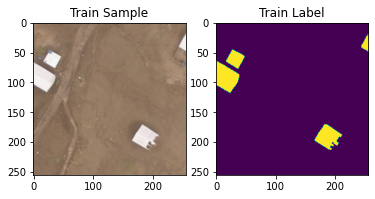

In [7]:
xp_name = "18242:3909_256oc_EB1-Unet-qubvel_lr1e-3_wd1e-5_b16_ep500_BCE_RLRonPlateau(min1e-8)"

ChainedTrain = ConcatDataset([Train, InRGB_Train, HFLIP_Train, VFLIP_Train, BLUR_Train, CON_Train, SOL_Train])
ChainedVal = ConcatDataset([Val, HFLIP_Val, VFLIP_Val])

# plot a sample
train_pair = random.choice(ChainedTrain)
print(train_pair[0].shape, train_pair[1].shape)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(train_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('Train Sample')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(train_pair[1].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('Train Label')

training_loop(n_epochs = 500,
             optimizer = torch.optim.Adam(Net.parameters(), lr = 1e-3, weight_decay = 1e-5),
             model = Net,
             in_channels = 3,
             out_channels = 1,
             xp_name = xp_name,
             loss_fn = nn.BCELoss(reduction = 'mean'),
             train_loader = DataLoader(ChainedTrain,
                                       batch_size = 16, shuffle = True),
             val_loader = DataLoader(ChainedVal,
                                     batch_size = 16, shuffle = True),
             checkpoint_freq = 10,
             val_freq = 10)

torch.cuda.empty_cache()

In [8]:
torch.cuda.empty_cache()

## Prediction on Test dataset

Text(0.5, 1.0, 'LBL')

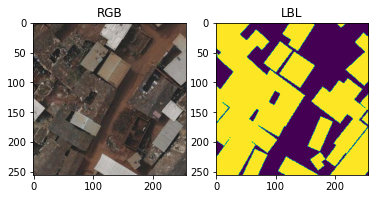

In [19]:
# plot a sample
test_pair = random.choice(Test)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 3.7631421037076507e-06, Maximum: 0.005593538749963045, Mean: 0.0017973900539800525, St dev: 0.0013424046337604523
True Positive = 35749, True Negative = 18589, False Negative = 5071 False Positive = 6127
Precision = 0.853687047958374, Recall = 0.875771701335907, Specificity = 0.7521039247512817, Overall Accuracy = 0.829132080078125, Intersection-over-Union = 0.761475682258606, Dice-Score = 0.8645883202552795


Text(0.5, 1.0, 'Binary Segmentation')

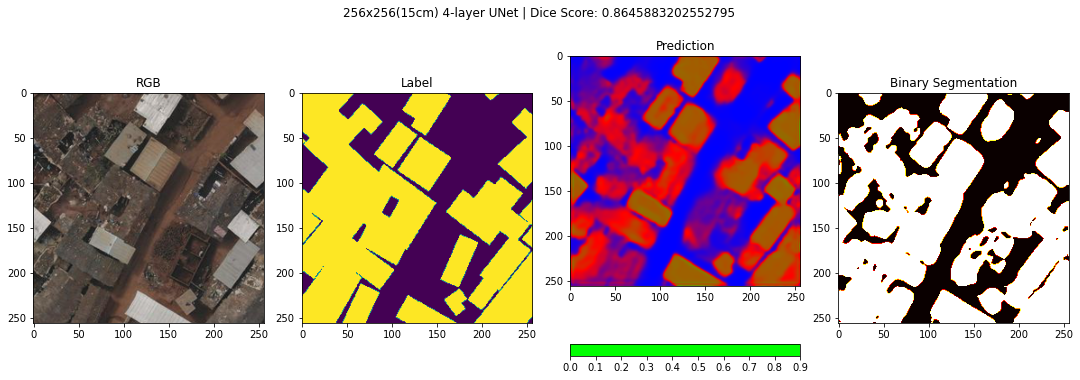

In [20]:

Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5,
               encoder_weights = None, decoder_use_batchnorm = True, 
               decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None,
               in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

#Net = Four_UNet()

checkpoint_dir = os.path.abspath("/home/mnt/HOTOSM_data/checkpoints")
#checkpoint_dir = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/best_weights")
best_iter = "_iter_548820.pth"

NN_weights = os.path.join(checkpoint_dir, xp_name, xp_name + best_iter)

NN_weights = torch.load(NN_weights, map_location = device)

Net.load_state_dict(NN_weights["Model:"])
Net.to(device = "cpu")
Net.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = "cpu")
lbl = lbl.to(device = "cpu")
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Net(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))


print("True Positive = {0}, True Negative = {1}, False Negative = {2} False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2}, Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) 4-layer UNet | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')


In [21]:
# Loading testing batch
test_loader = DataLoader(Test, batch_size = 1, shuffle = True)
Net.to(device = device)

idx = []
png_ls = []
Dice_ls = []
TP_ls = []
TN_ls = []
FN_ls = []
FP_ls = []
Precision_ls = []
Recall_ls = []
Specificity_ls = []
OA_ls = []
IoU_ls = []

for i, (img, lbl) in tqdm(enumerate(test_loader), total = len(test_loader)):
    img = img.to(device = device)
    lbl = lbl.to(device = device)

    with torch.no_grad():
        prediction = Net(img)
        prediction = prediction.squeeze(0)
        lbl = lbl.squeeze(0)

        pred_BOOL = (prediction > 0.001).to(torch.float32)

        # Booleanise
        pred_BOOL = pred_BOOL.bool()
        lbl = lbl.bool()

        # 1st order statistics
        TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
        TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
        FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
        FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

        # 2nd order statistics
        Precision = (TP / (TP + FP))
        Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
        Specificity = (TN / (FP + TN)) #True Negative Rate
        OA = ((TP + TN) /(TP + TN + FP + FN))
        IoU = (TP / (TP + FN + FP))
        Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

        TP = TP.detach().cpu().numpy()
        TN = TN.detach().cpu().numpy()
        FN = FN.detach().cpu().numpy()
        FP = FP.detach().cpu().numpy()
        Precision = Precision.detach().cpu().numpy()
        Recall = Recall.detach().cpu().numpy()
        Specificity = Specificity.detach().cpu().numpy()
        OA = OA.detach().cpu().numpy()
        IoU = IoU.detach().cpu().numpy()
        Dice = Dice.detach().cpu().numpy()

        idx.append(i)
        TP_ls.append(TP)
        TN_ls.append(TN)
        FN_ls.append(FN)
        FP_ls.append(FP)
        Precision_ls.append(Precision)
        Recall_ls.append(Recall)
        Specificity_ls.append(Specificity)
        OA_ls.append(OA)
        IoU_ls.append(IoU)
        Dice_ls.append(Dice)

for j in Test.png_dir:
    png_ls.append(os.path.basename(j))

df = {"id": idx,
      "png": png_ls,
      "Dice_score": Dice_ls,
      "True_Positive": TP_ls,
      "True_Negative": TN_ls,
      "False_Negative": FN_ls,
      "False_Positive": FP_ls,
      "Precision": Precision_ls,
      "Recall": Recall_ls,
      "Specificity": Specificity_ls,
      "Overall Accuracy": OA_ls,
      "IoU": IoU_ls}
      
results_csv = pd.DataFrame(df)
print(xp_name + best_iter, "mean Dice Score = {0}, mean Precision = {1}, mean Recall = {2}, mean Specificity = {3}, mean OA = {4}, mean IoU = {5}".format(np.nanmean(Dice_ls), np.nanmean(Precision_ls), np.nanmean(Recall_ls), np.nanmean(Specificity_ls), np.nanmean(OA_ls), np.nanmean(IoU_ls)))

100%|██████████| 435/435 [00:17<00:00, 24.89it/s]

18242:3909_256oc_EB1-Unet-qubvel_lr1e-3_wd1e-5_b16_ep500_BCE_RLRonPlateau(min1e-8)_iter_548820.pth mean Dice Score = 0.828467071056366, mean Precision = 0.7600162625312805, mean Recall = 0.8970312476158142, mean Specificity = 0.9012280106544495, mean OA = 0.9282568693161011, mean IoU = 0.7141541242599487


In [22]:
print(results_csv.info(), results_csv["Dice_score"].describe(), results_csv.head())

log_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/HOTOSM_OAM_codeV2/iter_log")

results_csv.to_csv(os.path.join(log_path, xp_name + best_iter + ".csv"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                435 non-null    int64 
 1   png               435 non-null    object
 2   Dice_score        435 non-null    object
 3   True_Positive     435 non-null    object
 4   True_Negative     435 non-null    object
 5   False_Negative    435 non-null    object
 6   False_Positive    435 non-null    object
 7   Precision         435 non-null    object
 8   Recall            435 non-null    object
 9   Specificity       435 non-null    object
 10  Overall Accuracy  435 non-null    object
 11  IoU               435 non-null    object
dtypes: int64(1), object(11)
memory usage: 40.9+ KB
None count           435
unique          435
top       0.6217819
freq              1
Name: Dice_score, dtype: object    id                        png  Dice_score True_Positive True_Negative  \
0   0 